In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import logging
import glob
import random
import pydicom
import json

sys.path.append('../')
from rsna import utils

In [3]:
import boto3

In [4]:
import PIL


In [5]:
! ls /mirco-kaggle/rsna

GCP Credits Request Link - RSNA.txt  stage_1_test_images
all.zip				     stage_1_test_images.zip
label_map.pbtxt			     stage_1_train_images
stage_1_detailed_class_info.csv      stage_1_train_images.zip
stage_1_sample_submission.csv	     stage_1_train_labels.csv


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
import sys
sys.path.append('../')

In [8]:
RAW_DATA_DIR = "/mirco-kaggle/rsna/"

In [9]:
train_dicom_dir = os.path.join(RAW_DATA_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(RAW_DATA_DIR, 'stage_1_test_images')

train_labels = os.path.join(RAW_DATA_DIR, 'stage_1_train_labels.csv')
detailed_class_info  = os.path.join(RAW_DATA_DIR, 'stage_1_detailed_class_info.csv')

# Data set exploration

In [10]:
df_detailed_class_info = pd.read_csv(detailed_class_info)
df_detailed_class_info.head(3)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal


No Lung Opacity / Not Normal    11500
Lung Opacity                     8964
Normal                           8525
Name: class, dtype: int64
total: 28989


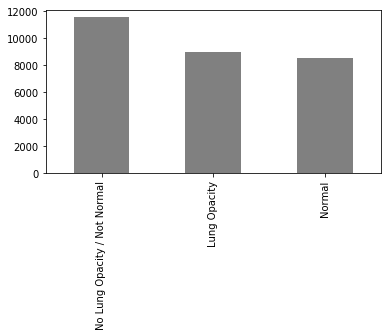

In [11]:
df_plot = df_detailed_class_info['class'].value_counts()

df_plot.plot(kind='bar',
             color='gray',
             figsize=(6,3))


print(f"{df_plot}")
print(f"total: {sum(df_plot)}")

In [15]:
df_train_labels = pd.read_csv(train_labels)
df_train_labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


## make annotation dict

In [16]:
label_map = {0: 'other', 1: 'high_density'}

In [17]:
df_train_labels = df_train_labels.assign(label_idx = df_train_labels['Target']).head(5000)
df_train_labels['label'] = df_train_labels['label_idx'].apply(lambda x: label_map[x])

In [18]:
df_train_labels.head(5)

,patientId,x,y,width,height,Target,label_idx,label
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,0,other
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,0,other
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,0,other
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,0,other
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,1,high_density


In [19]:
annotation_dict = utils.get_annotation_dict(df_train_labels=df_train_labels)

In [20]:
list(annotation_dict.items())[0:5]

[('0004cfab-14fd-4e49-80ba-63a80b6bddd6', []),
 ('00313ee0-9eaa-42f4-b0ab-c148ed3241cd', []),
 ('00322d4d-1c29-4943-afc9-b6754be640eb', []),
 ('003d8fa0-6bf1-40ed-b54c-ac657f8495c5', []),
 ('00436515-870c-4b36-a041-de91049b9ab4',
  [{'xmin': 264,
    'xmax': 477,
    'ymin': 152,
    'ymax': 531,
    'label': 'high_density',
    'label_idx': 1},
   {'xmin': 562,
    'xmax': 818,
    'ymin': 152,
    'ymax': 605,
    'label': 'high_density',
    'label_idx': 1}])]

## make tfrecords

In [21]:
annot = utils.Annot(annotation_dict)

In [22]:
image = annot.create_ml_set(frame_path=train_dicom_dir, out_path='../ml/v1/data/')

train size: 3242
train size: 811


## visualize things

In [78]:
annot.get_min_max_bbox(frame_id='00436515-870c-4b36-a041-de91049b9ab4')

{'xmin': [264, 562],
 'xmax': [477, 818],
 'ymin': [152, 152],
 'ymax': [531, 605],
 'labels': ['high_density', 'high_density']}

In [79]:
annot.get_min_size_bbox(frame_id='00436515-870c-4b36-a041-de91049b9ab4')

{'xmin': [264, 562],
 'widths': [213, 256],
 'ymin': [152, 152],
 'heights': [379, 453],
 'labels': ['high_density', 'high_density']}

In [80]:
len(annot)

78

In [81]:
image = utils.Annot.get_image(frame_path=train_dicom_dir, frame_id='00436515-870c-4b36-a041-de91049b9ab4')

In [84]:

def get_bbox_from_tfrec(example, label_idx, source="detection"):
    """Extracting bbox from tf record files.
    Args:
        source: Either detect or object, default value is detect.
        example: tf.train.Example()
        label_idx: idx of the bbox.
    Returns:
        xmin, xmax, ymin, ymax of boxes.
    Raises:
        ValueError: in case the user mistakenly type wrong source.
    """
    if source not in ["object", "detection"]:
        raise ValueError("The source has to be either detect or object.")

    xmin = example.features.feature[f"image/{source}/bbox/xmin"].float_list.value[label_idx]
    xmax = example.features.feature[f"image/{source}/bbox/xmax"].float_list.value[label_idx]
    ymin = example.features.feature[f"image/{source}/bbox/ymin"].float_list.value[label_idx]
    ymax = example.features.feature[f"image/{source}/bbox/ymax"].float_list.value[label_idx]

    return xmin, xmax, ymin, ymax

def get_frame_metadata_from_tfrec(example):
    """Get basic frame information from tfrecord files.
    Args:
        example: tf.train.Example()
    Returns:
        frame_id, height, width of the frame.
    """
    frame_id = example.features.feature["image/filename"].bytes_list.value[0]
    height = example.features.feature["image/height"].int64_list.value[0]
    width = example.features.feature["image/width"].int64_list.value[0]

    return frame_id, height, width


def _from_gt_tfrec(tfrec_path):
    annots = {}
    for string_record in tf.python_io.tf_record_iterator(path=tfrec_path):
        example = tf.train.Example()
        example.ParseFromString(string_record)

        frame_id, height, width = get_frame_metadata_from_tfrec(example)
        labels = example.features.feature["image/object/class/text"].bytes_list.value

        deepturn_annots = []
        for idx, label in enumerate(labels):
            xmin, xmax, ymin, ymax = get_bbox_from_tfrec(source="object",
                                                               example=example,
                                                               label_idx=idx)

            deepturn_annots.append(
                dict(
                    name=label.decode("utf-8"),
                    xmin=round(xmin * width),
                    xmax=round(xmax * width),
                    ymin=round(ymin * height),
                    ymax=round(ymax * height),
                )
            )
        annots[frame_id.decode("utf-8")] = deepturn_annots

    return annots


_from_gt_tfrec('../ml/v1/data/train.tfrec')

{'/mirco-kaggle/rsna/stage_1_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm': [],
 '/mirco-kaggle/rsna/stage_1_train_images/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm': [],
 '/mirco-kaggle/rsna/stage_1_train_images/00322d4d-1c29-4943-afc9-b6754be640eb.dcm': [],
 '/mirco-kaggle/rsna/stage_1_train_images/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm': [],
 '/mirco-kaggle/rsna/stage_1_train_images/00569f44-917d-4c86-a842-81832af98c30.dcm': [],
 '/mirco-kaggle/rsna/stage_1_train_images/006cec2e-6ce2-4549-bffa-eadfcd1e9970.dcm': [],
 '/mirco-kaggle/rsna/stage_1_train_images/00704310-78a8-4b38-8475-49f4573b2dbb.dcm': [{'name': 'high_density',
   'xmin': 323,
   'xmax': 483,
   'ymin': 577,
   'ymax': 681},
  {'name': 'high_density',
   'xmin': 695,
   'xmax': 857,
   'ymin': 575,
   'ymax': 712}],
 '/mirco-kaggle/rsna/stage_1_train_images/009eb222-eabc-4150-8121-d5a6d06b8ebf.dcm': [],
 '/mirco-kaggle/rsna/stage_1_train_images/00a85be6-6eb0-421d-8acf-ff2dc0007e8a.dcm': [],
 '/mirco-kaggle/rsn

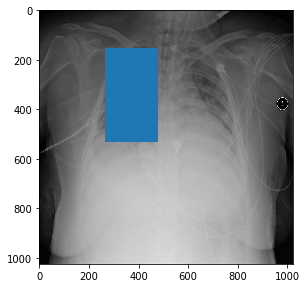

In [85]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 



plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# masked = np.zeros(image.shape[:2])

# plt.imshow(masked, cmap='gray')
# plt.axis('off')

# print(image_fp)
# print(class_ids)


rect = plt.Rectangle((264, 152), 213, 379)
# plt.Rectangle()

plt.gca().add_patch(rect)